In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import math
%matplotlib inline

employee = pd.read_csv("HR_comma_sep.csv")

employee = employee.rename(columns={'average_montly_hours':'avg_hours'})

# Introduction

I'd like to look at a dataset of employee records from a large company. More specifically, the data contains each employee's workload, evaluation, job satisfaction, and other measures along with a binary for whether or not said employee has left the company. We can thus use it to try to glean some information about what factors influence employee turnover, which can be a big problem for any human resources department or company in today's competitive market for talent.

I'll first try to hone in on some interesting correlations and learnings as relates to employees quitting. Specifically, I'll look to probe on the topic of "burnout," and whether employees that seem to have a high workload are quitting at a higher rate and, if so, why exactly that is. However, given that the data is somewhat limited in its level of description of each employee's circumstances and can only hint at more specific hypotheses, I'll use these initial learnings to propose a further experiment to expand on what we uncover.

First, let's just take a quick overview of the data.

In [2]:
#Checking data types and that there are no nulls
print('Null Counts')
print(employee.isnull().sum())
print('\n')
print('Data Types')
print(employee.dtypes)

Null Counts
satisfaction_level       0
last_evaluation          0
number_project           0
avg_hours                0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64


Data Types
satisfaction_level       float64
last_evaluation          float64
number_project             int64
avg_hours                  int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
sales                     object
salary                    object
dtype: object


In [3]:
# Familiarizing myself with the different metrics and their scales
employee.describe()

,satisfaction_level,last_evaluation,number_project,avg_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


Now that we've taken a quick overview of the metrics, let's quickly see if there's any metrics that seem to differ drastically among employees that stay versus ones that leave.

In [4]:
employee.groupby('left').mean()

,satisfaction_level,last_evaluation,number_project,avg_hours,time_spend_company,Work_accident,promotion_last_5years
left,,,,,,,
0,0.666810,0.715473,3.786664,199.060203,3.380032,0.175009,0.026251
1,0.440098,0.718113,3.855503,207.419210,3.876505,0.047326,0.005321


As we can see above, employees that leave are generally less satisfied with their jobs, work longer hours, and are less likely to have been promoted recently. These all make sense logically. Let's look more specifically at the number of projects being handled and average hours per month worked as they relate to likelihood to quit to see if there appears to be a linear relationship.

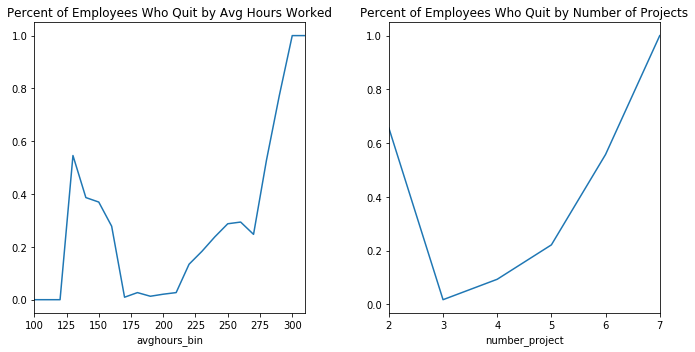

In [5]:
# Round hours worked to the nearest ten
def myround(x, base=10):
    return base * round(x/base)

# Add a column with hours worked rounded to the nearest ten, quickly check results
employee['avghours_bin'] = myround(employee['avg_hours'])
employee.head(10)

# Plot average hours worked and number of projects versus likelihood of leaving
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Percent of Employees Who Quit by Avg Hours Worked")
employee.groupby('avghours_bin').mean()['left'].plot()
plt.subplot(1,2,2)
plt.title("Percent of Employees Who Quit by Number of Projects")
employee.groupby('number_project').mean()['left'].plot()
plt.tight_layout()
plt.show()

Interestingly, there is an overall higher likelihood of quitting on the extreme low end of projects or work hours. These may be people that are part time, seasonal, or low wage roles that have high turnover. Or, these could be employees whose roles are being phased out or diminished, motivating them to leave. 

However, we're more interested in the people on the higher end of the workload continuum. Confirming what we saw with the averages, it appears that those who work high hours and are assigned an inordinately high number of projects demonstrate a much higher likelihood of quitting. This fits our general notion that a lot of employees who quit simply burn out after being overworked. There is an alternative explanation, though. It could be that many of these employees are simply "high performers," who naturally take on more work. If they quit at a higher rate, it may be because these employees are likelier to be sought out by other firms wishing to hire them.

Let's look at some of the other variables and their relationships to one another to illuminate whether the issue has to do with burnout or losing high performers.

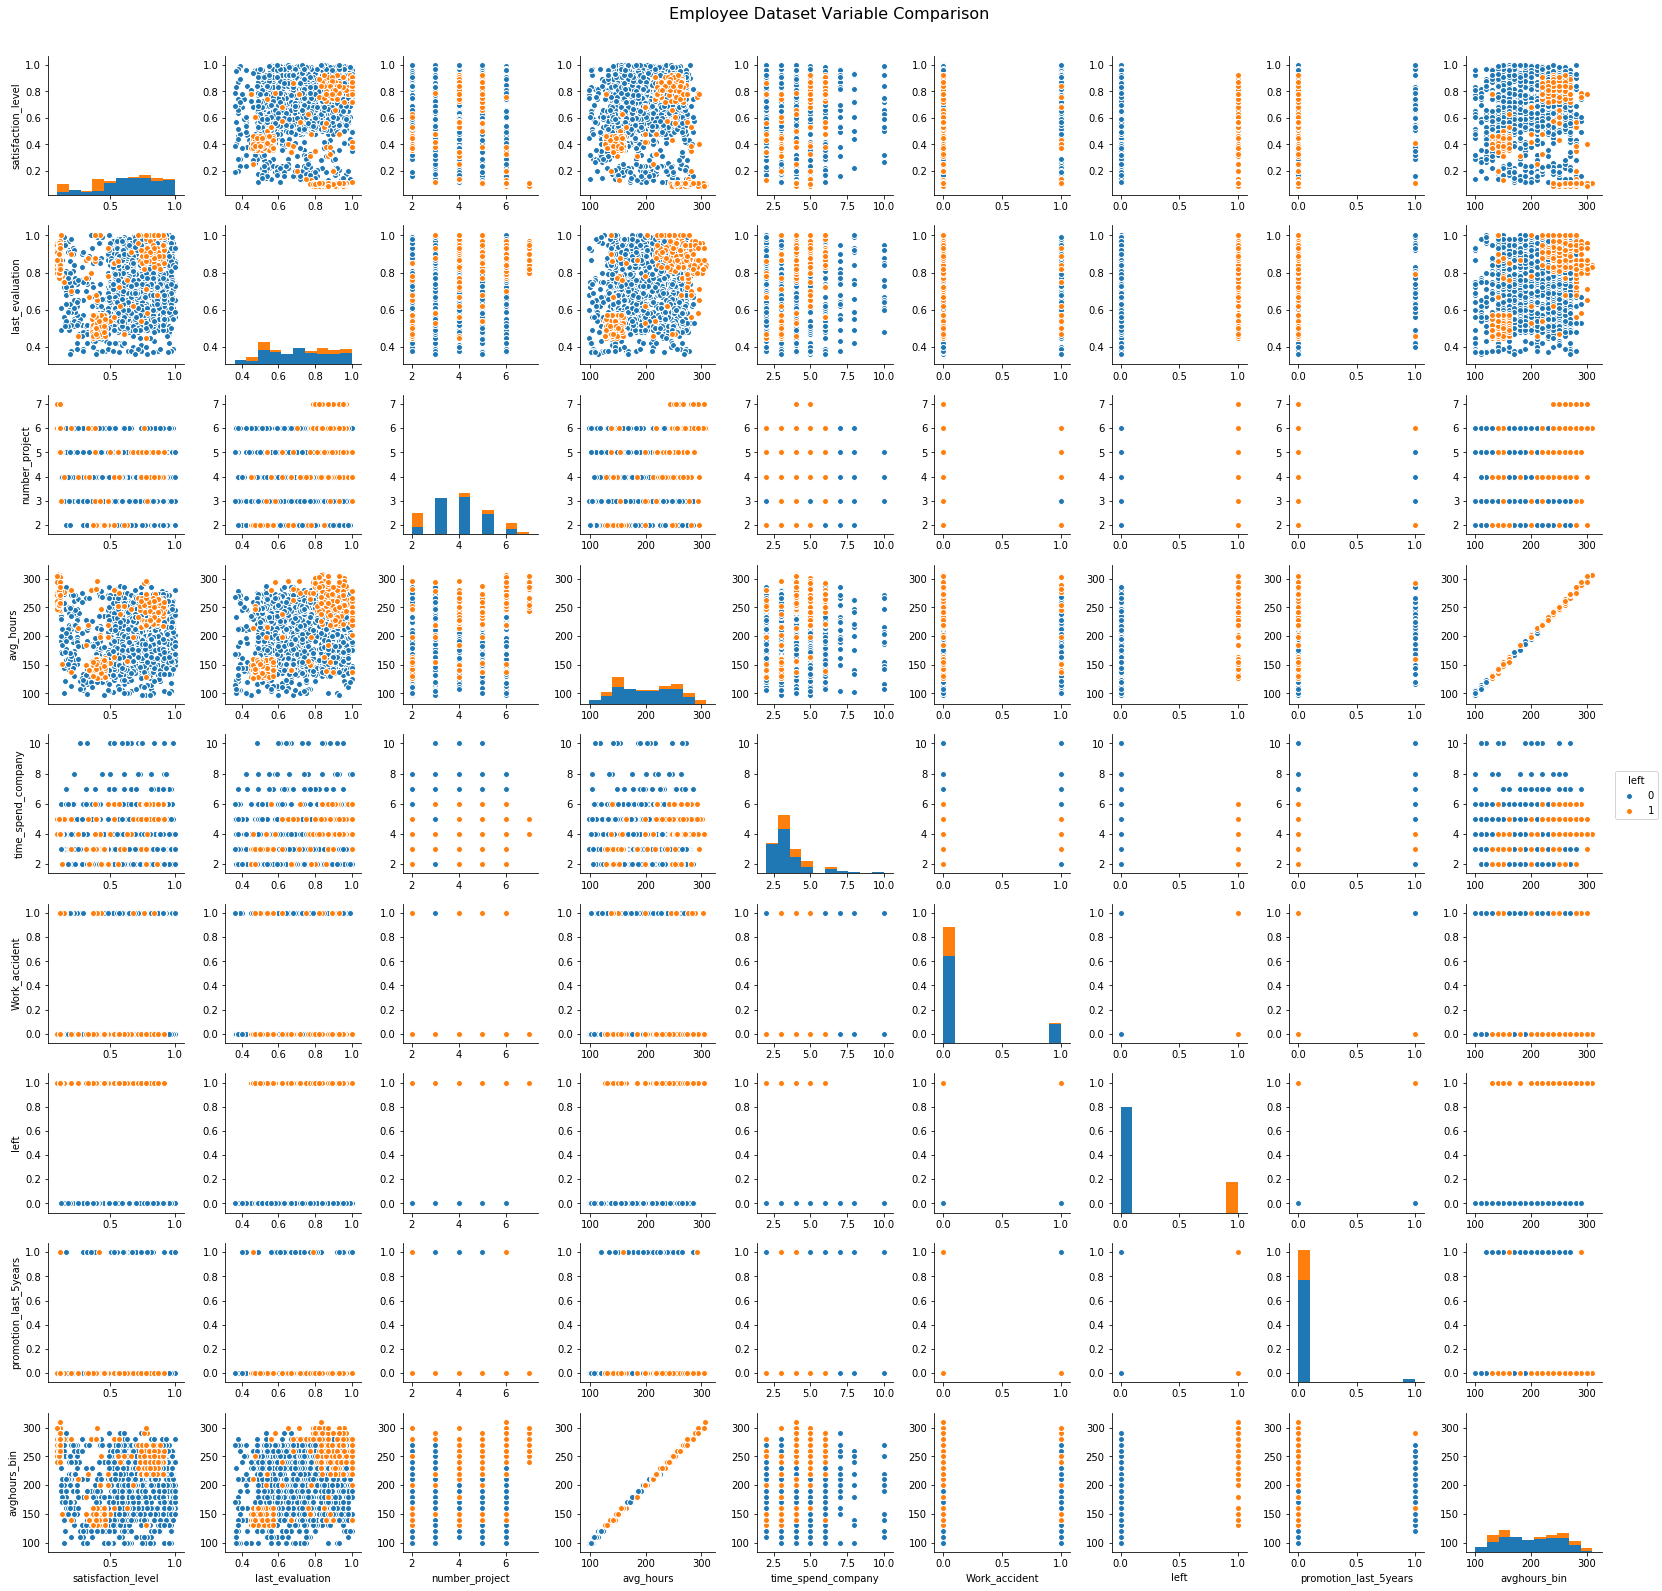

In [6]:
pairplot = sns.pairplot(employee.sample(frac=.1),hue='left')
plt.suptitle('Employee Dataset Variable Comparison',fontsize=16)
plt.subplots_adjust(top=0.95)
plt.show()

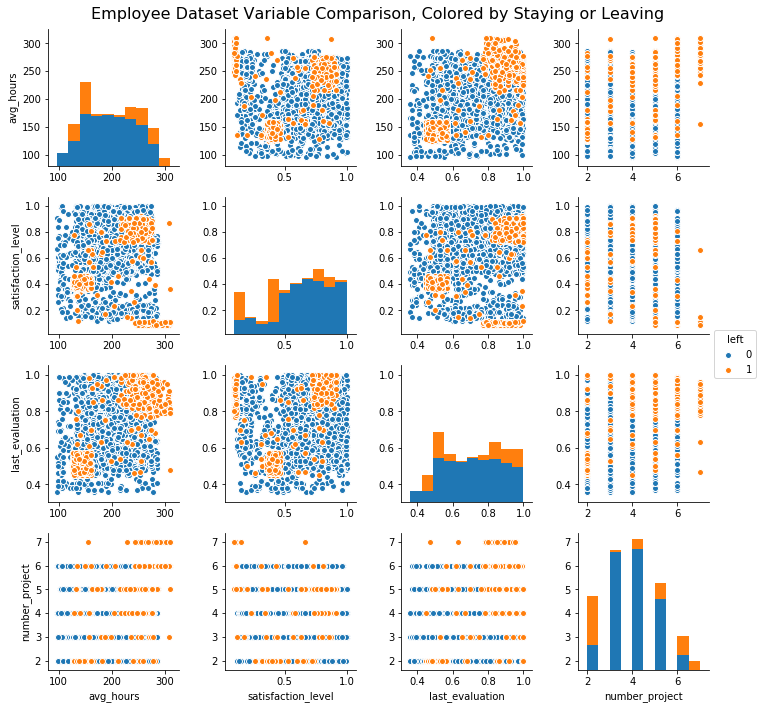

In [7]:
pairplot = sns.pairplot(employee.sample(frac=.15),vars=['avg_hours','satisfaction_level','last_evaluation','number_project'],hue='left')
plt.suptitle('Employee Dataset Variable Comparison, Colored by Staying or Leaving',fontsize=16)
plt.subplots_adjust(top=0.95)
plt.show()

There's a few very interesting things about the above, particularly as relates to the average hours worked. We see that among employees that work many hours, some that quit were extremely unsatisfied with the job and may have burnt out, but a large portion actually were satisfied with their job and still left. Additionally, many of those who worked long hours and left were in fact highly rated employees. The same general trends can be seen for number of projects, another proxy for high performance.

There's certainly some evidence building that there may be more to the story than simply that employees that work a lot burn out and quit. There seems to be a group of people that work hard and take on lots of projects, but seem to enjoy their jobs. Let's zero in on these folks a little more.

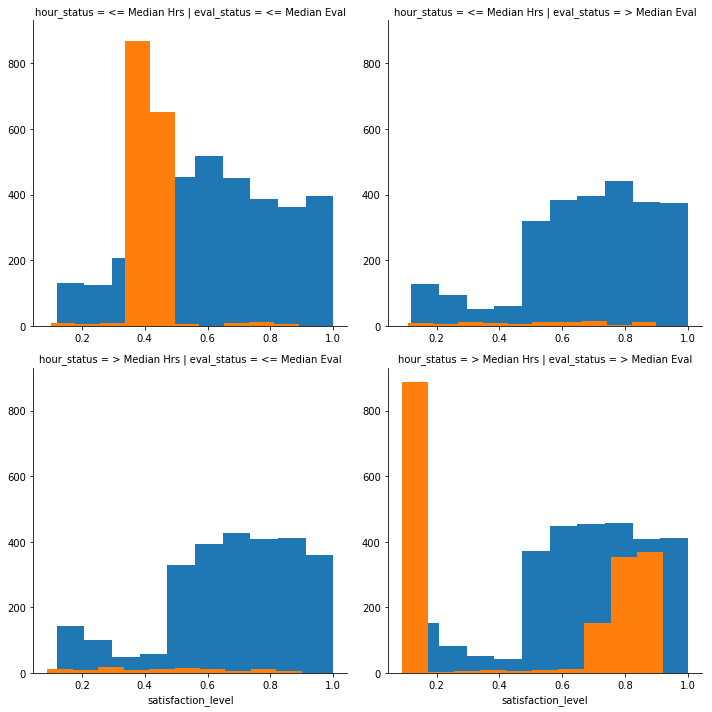

In [8]:
# Adding columns for whether employees are above or below the median for hours and evaluations
employee['hour_status'] = np.where(employee['avg_hours']>employee['avg_hours'].median(), '> Median Hrs', '<= Median Hrs')
employee['eval_status'] = np.where(employee['last_evaluation']>employee['last_evaluation'].median(), '> Median Eval', '<= Median Eval')

# Plotting a facet grid to compare how satisfaction compares among these groups, with whether the employee left layered in
facet = sns.FacetGrid(employee,row='hour_status',col='eval_status',hue='left',size=5)
facet = facet.map(plt.hist,"satisfaction_level")
plt.show()

The chart on the bottom right is most revealing. The peak on the right shows that among workers who work more hours than the average employee and are better reviewed than the average employee, there's a not insignificant portion of employees who also quite enjoy their job. If they're happy despite working those long hours and their managers agree they're doing a good job, I think it's likely that many of these people are simply high performers who are quitting not because of burnout, but because they're sought by other companies.

My research proposal will be based on this idea.

# Experimental RFC

### Background
Understanding the drivers of employee retention and turnover is critical to the success of any business. Companies that are aware of what motivates employees to leave are better equipped to take effective action to retain them, which saves money and preserves a high level of talent among its workforce.

From our initial analysis of the employee data from this particular company, it is clear that employees with high workloads (in terms of hours or their number of projects) are particularly prone to attrition. This brings to mind the popular topic of employee "burnout," whereby employees become overwhelmed with the volume of work, lose motivation and efficacy, and eventually choose to quit. While this is a phenomenon observable with some of the employees that quit, we saw some interesting trends in the data that point to a different effect motivating "hardworking" employees to quit. Since a fair portion of these workers actually have a fairly high satisfaction level and have been given strong evaluations, it is possible that rather than "burning out," these employees have been sought out by other companies because of their strong work ethic and output.

Since the dataset cannot answer this question specifically, we'll need to conduct an experiment to confirm or deny whether this phenomenon of hardworking employee "poaching" exists, and to what degree.

### Hypothesis 
Employees with high hours worked and projects assigned to them who leave the company will have interacted with more recruiters than lower workload employees who leave.

### Experiment Overview
The vehicle for testing our hypothesis will be a survey given to departing employees. This can be administered by the HR department as part of the exit interview process. It will be a text questionnaire administered by computer in order to try to diminish the effect of any employee shyness in social situations or reticence to share what they consider sensitive information face to face. Additionally, assurances should be given that the data collected will be anonymized. By this we mean that no one will be able to see the responses as they are collected, and whenever the data is accessed by an HR employee on the back end, it is stripped of the corresponding employee name and ID.
##### Key and Secondary Metrics
The key metric we will be looking for is the number given in response to: "How many interactions have you had with a recruiter in the last six months?" There are a few secondary questions we will also ask which could serve as additional metrics in evaluating the results:
- Did you have another job lined up before your departure?
- Are you leaving the company with a positive view of it, overall?

##### Resulting Data & Treatment/Control Groups
The results from the survey, in which the employee will enter their employee ID (under guarantee of anonymization on the back end), can then be joined with the employee dataset as additional columns. In order to test our hypothesis, we will compare these two groups on the key metric:
- Employees who left and were at or above the 75th percentile in average hours worked and projects assigned
- Employees who left and were below the 75th percentile in average hours worked or projects assigned

##### Sample Size and Expectations
We'll need to estimate the sample size required to be confident that we can reject the null hypothesis (that employees at this firm taking on high workloads does not make them more likely to be recruited by other companies), should our data show this. A reasonable barometer for this is whether or not our t-value is >= 3, corresponding to roughly a p-value of 0.05 or less, per the following formula:
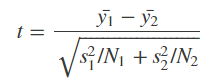
Let's first reduce this formula to be solvable for N assuming we know what the other variables are.



<center>**t = (mean1 - mean2) / sqrt((var1/n1)+(var2/n2))**</center>
<br>
<center>**t = (mean1 - mean2) / sqrt((var/n1)+(var/(n1*3)))**</center>
<br>
<center>**t = (mean1 - mean2) / sqrt((var/n1)+(1/3)*(var/(n1)))**</center>
<br>
<center>**t = (mean1 - mean2) / sqrt((4/3)*(var/n1))**</center>
<br>
<center>**t = (mean1 - mean2) / sqrt((4/3)/n1)*var)**</center>
<br>
<center>**t = (mean1 - mean2) / sqrt((4/3)/n1)*std **</center>
<br>
<center>**t = ((mean1 - mean2) / std) \* sqrt(n1\*(3/4)) **</center>
<br>
<center>**t / sqrt(n1*3/4) = ((mean1 - mean2) / std)**</center>
<br>
<center>**sqrt(n1\*3/4) = (t*std/(mean1-mean2))**</center>
<br>
<center>**(n1\*3/4) = (t*std/(mean1-mean2))^2**</center>
<br>
<center>**n1 = (4/3)\*(t \* std/(mean1-mean2))^2**</center>

Now that we have the formula for calculating n based on the other experimental variables, we need to go ahead and solve for it. To do so, we'll need to estimate the difference in means and standard deviation we expect from the experiment. We don't have any metric at hand to estimate these variables, so we will start with reasonable guesses. I propose that we'll use 2 for the effect size, indicating that the "hard workers" were on average in contact with a recruiter 2 more times in the past six months than those that were not in that group. For the standard deviation, I'll use a value of 4, since contacts with a recruiter can vary pretty widely between people. Let's calculate the sample size we'd need based on this assumption.

In [25]:
# n = 2*(t * std/(mean1-mean2))^2
t = 3
std = 4
meandiff = 2

n1 = (4/3)*((t*std)/meandiff)**2
n2 = n1*3
total_sample = n1+n2
print('For group 1, we would expect to need {:.0f} people'.format(n1))
print('For group 2, we would expect to need {:.0f} people'.format(n2))
print('In total, we would expect to need a sample of {:.0f} people'.format(total_sample))

For group 1, we would expect to need 48 people
For group 2, we would expect to need 144 people
In total, we would expect to need a sample of 192 people


So we'd estimate that we need a sample size of about 192 people, which we can round to 200. This is quite a large number of employees. However, we are dealing with a fairly large company which employs about 15K people. Let's do a quick sanity check to assess whether the experiment is feasible.

According to research by [Compensation Force](http://www.compensationforce.com/2014/02/2013-turnover-rates-by-industry.html), the average voluntary turnover across industries is about 10%. Using this as a benchmark, we can calculate how long it may take for this many employees to leave the company.

In [28]:
total_sample = 200
total_employees = 15000
annual_turnover = 0.10
annual_employees_lost = annual_turnover * total_employees

months_sample_collection = (total_sample/annual_employees_lost)*12
print('We estimate that collecting the necessary sample size will take {:.1f} months.'.format(months_sample_collection))

We estimate that collecting the necessary sample size will take 1.6 months.


Based on typical turnover, we'd expect to have the results collected within a little over 1.5 months. This is a reasonable timeframe, especially given the potential longer term value of learnings that we could gain from the experiment. As such, we should continue with a target sample size of 200 subjects.

However, we must keep in mind that this estimate of adequate sample size is based on reasonable guesses for effect size and variance. We should run the experiment as a "pilot" until we have about 20 respondents (10% of total) and then reflect on the results so far. This should confirm whether or not our initial expectations for the difference in means and standard deviation were correct. If they are and a recalculation of the necessary n value based on the "actual" standard deviation and effect leads to a similar (or still reasonably small) estimate for total sample size, we can resume the experiment with more confidence.

### Evaluation of the Data
After we've completed the data collection process, we will need to correctly evaluate the data. 

The first step in doing so is to check the distributional composition of our experiment subjects versus the observations we have of previously departed employees. Assuming nothing drastic has changed with the organization of the company, we'd assume that there would be similar compositions of employees of different salary types, departments, likelihood of a work injury, etc. If there is a drastic difference, we need to keep our guard up that there is a larger effect that is affecting our sample and causing selection bias. We should also try to confirm that we are isolating the "workload" attribute of the two groups in our sample by testing whether they have similar compositions between them along the same lines.

Next, we will calculate the t-test and corresponding p-value given the difference in means for our key metric between our two sample groups. Additionally, we should perform the same t-test and p-value analysis among different key subgroups (like by department), to confirm that our view of the aggregate effect is not victim to Simpson's paradox. If the t-value we generate is above 3 and the corresponding p-value below 0.5, we can reject the null hypothesis and conclude that these employees are indeed recruited at a higher rate.

For further clarity, we should perform a proportional z-test to compare the means as well. This is useful since we know the result per observation lies between 1 and 0, and this test can take this into account when comparing the means. A p-value below 0.05 for this test should provide even more confidence in rejecting the null hypothesis.

Additionally, it is worth taking a look at the results of the secondary metrics we have collected. If "hardworking" departing employees demonstrate a higher rate of having jobs lined up before they've left and are leaving the company with a positive image of it, this adds further credence to the idea that some of these employees are being drawn to other companies because of their desirability rather than quitting due to burnout. If these track completely differently from how we'd expect, we may need to evaluate if there is another effect at play.

### A note on our approach

Lastly, now that the parameters and methodology of our experiment have been adequately explained, it is worth addressing some of the shortcomings of our approach and explaining why it is still the best route to take given the question we're asking.

One potential shortcoming is that, by performing the experiment via an exit interview for employees leaving the company, we are foreclosing the possibility of generating answers for employees that stay. For example, it is possible that even though we're noticing a big delta between hardworking and non-hardworking employees in the resulting data, it may be that the hardworking employees who remain were also frequently in contact with recruiters. We would then wonder if the recruitment was actually a cause of employees leaving, rather than just a circumstance of being a high performer. I think our approach is still the best one to take for a few reasons:
- It's not very likely that there wouldn't be any difference in recruitment activity been hard workers who leave and don't leave. As such, we can reasonably conclude that the effect size in our data set does reflect at least a partial cause of the departure given what we already know about satisfied, hard working employees leaving.
- Asking all employees would introduce some other issues, including difficulty in getting honest answers (since they are still employed)

Another option in consideration would have been to conduct a more "public" survey of the data we're after. We could conduct a randomized survey of American employees via phone or online. We could also scrape a site like LinkedIn for information about job tenure, qualifications, and recruitment. While these alternatives would potentially make collection faster or cheaper, these also present issues:
- Critically, we would no longer be able to ascertain company-specific results. The benefit of performing the exit interview is that these are **actual** employees of the company and the results thus reflect the real, immediate, and maybe particular drivers of its retention trends. 
- Data from the public at large could be subject to all kinds of biases resulting from industry changes, macroeconomic outlook, and other shifts that could obscure what is happening with the company in question, which is what we really care about.

So, while we aware that our experiment is necessarily imperfect, we believe it to be the best approach for answering the question at hand.